# Package ingest

In [25]:
# Importing Python packages

import pandas as pd
import numpy as np
import plotnine as p9
import os
import geopandas as gpd
from pathlib import Path


# Data ingest

In [26]:
# Reading in phased development data
phased_development = pd.read_csv('pipeline_example_output.csv').drop(['Unnamed: 0'],axis = 1)
phased_development.head(2)

,ProjectID,land_use,year,percent_development_pa,status,development_pa
0,2100.0,Residential - Villas Emiratis (Units),2024,0.5,Under Construction,0.0
1,5000.0,Residential - Villas Emiratis (Units),2024,0.5,Under Construction,0.0


In [27]:
# Reading in baseline TAZ data

sharepoint_path = f'C:/Users/{os.environ.get( "USERNAME" )}/Buro Happold'
project_path = Path(f"{sharepoint_path}/P060927 Plan Capital 2040 - 02_Documents/11_GIS/05 Urban Models")
ium_path = os.path.join(project_path,'ium_ad.gpkg')
zone_taz_2022 = gpd.read_file(ium_path, layer='zone_taz_2022')
zone_taz_2022.head(2)


,Z,SHAPE_Length,SHAPE_Area,NUM_OF_BUILDINGS,Calc_Total_Ex_GFA,Ex_GFA,RES_GFA,Residential_Labour_GFA,OFFICE_GFA,RETAIL_GFA,...,RETMAL_PRO,MEDCLI_PRO,MEDHOS_PRO,NONTER_PRO,TER_PRO,SCHPLCS_NT,SCHPLCS_TE,SCHPLCS_PR,SCHPLCS_SE,geometry
0,1044,46364.0,600150.0,675.0,295592.0,296118.0,269986.0,0.0,0.0,0.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((270352.336 2727199.707, 269735..."
1,1310,98338.0,6727847.0,541.0,223794.0,224058.0,152630.0,0.0,0.0,6490.0,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((278888.425 2680518.149, 278729..."


In [28]:
# Bringing in MP to TAZ development deltas

zone_taz_delta = gpd.read_file(ium_path, layer='zone_taz_delta')
zone_taz_delta.head(2)


,Z,ZONE,EPA,UPC_PRECIN,PRECINCT_N,ST_DIST_ID,ST_DIST_EN,UDM_DIST_I,UDM_DIST_E,REGION,...,score_ex_gfa_total_in_1km_rank,score_networkrail_nearest_m_rank,landmodel_component_rank_sum,landmodel_component_rank_mean,landmodel_component_rank_sum_rank,landmodel_component_rank_mean_rank,landmodel_development_score,gfa_per_ha,landmodel_limit_gfa_per_ha,geometry
0,1044,1044,None,7.0,Al Rahba,88.0,Al Rahba,1.0,AL RAHBA,ADM,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1410.696039,NaN,"MULTIPOLYGON (((270352.336 2727199.707, 269735..."
1,1310,1310,None,13.0,Baniyas,95.0,Al Nahda,54.0,AL NAHDA,ADM,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,153.469220,NaN,"MULTIPOLYGON (((278888.425 2680518.149, 278729..."


In [29]:
# Increasing the development capacity limits by a multiplier for prototyping purposes
multiplier = 2
zone_taz_delta['landmodel_limit_gfa_per_ha']  = zone_taz_delta['landmodel_limit_gfa_per_ha'] * multiplier
zone_taz_delta['max_capacity'] = zone_taz_delta['landmodel_limit_gfa_per_ha'] * zone_taz_delta['AREA']
zone_taz_delta.head(2)

,Z,ZONE,EPA,UPC_PRECIN,PRECINCT_N,ST_DIST_ID,ST_DIST_EN,UDM_DIST_I,UDM_DIST_E,REGION,...,score_networkrail_nearest_m_rank,landmodel_component_rank_sum,landmodel_component_rank_mean,landmodel_component_rank_sum_rank,landmodel_component_rank_mean_rank,landmodel_development_score,gfa_per_ha,landmodel_limit_gfa_per_ha,geometry,max_capacity
0,1044,1044,None,7.0,Al Rahba,88.0,Al Rahba,1.0,AL RAHBA,ADM,...,NaN,0.0,NaN,NaN,NaN,NaN,1410.696039,NaN,"MULTIPOLYGON (((270352.336 2727199.707, 269735...",NaN
1,1310,1310,None,13.0,Baniyas,95.0,Al Nahda,54.0,AL NAHDA,ADM,...,NaN,0.0,NaN,NaN,NaN,NaN,153.469220,NaN,"MULTIPOLYGON (((278888.425 2680518.149, 278729...",NaN


In [30]:
# Calculating gfa development capacity caps for each TAZ

taz_max_capacities = zone_taz_delta[['ZONE','masterplan_projectid','AREA','landmodel_limit_gfa_per_ha','2022_Ex_GFA']]
taz_max_capacities['max_capacity_gfa'] = taz_max_capacities['AREA'] * taz_max_capacities['landmodel_limit_gfa_per_ha']
taz_max_capacities = taz_max_capacities[['ZONE','masterplan_projectid','max_capacity_gfa','2022_Ex_GFA']]
taz_max_capacities.head(5)

C:\Users\jtindale\AppData\Local\Temp\ipykernel_12296\2998544897.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ZONE,masterplan_projectid,max_capacity_gfa,2022_Ex_GFA
0,1044,None,NaN,296118.0
1,1310,None,NaN,224058.0
2,2656,None,NaN,1091.0
3,1318,None,NaN,102379.0
4,1320,None,NaN,8977.0


C:\Users\jtindale\AppData\Local\Temp\ipykernel_12296\3955201484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\jtindale\AppData\Local\miniforge3\envs\landmodel\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 73'. Pick better value with 'binwidth'.


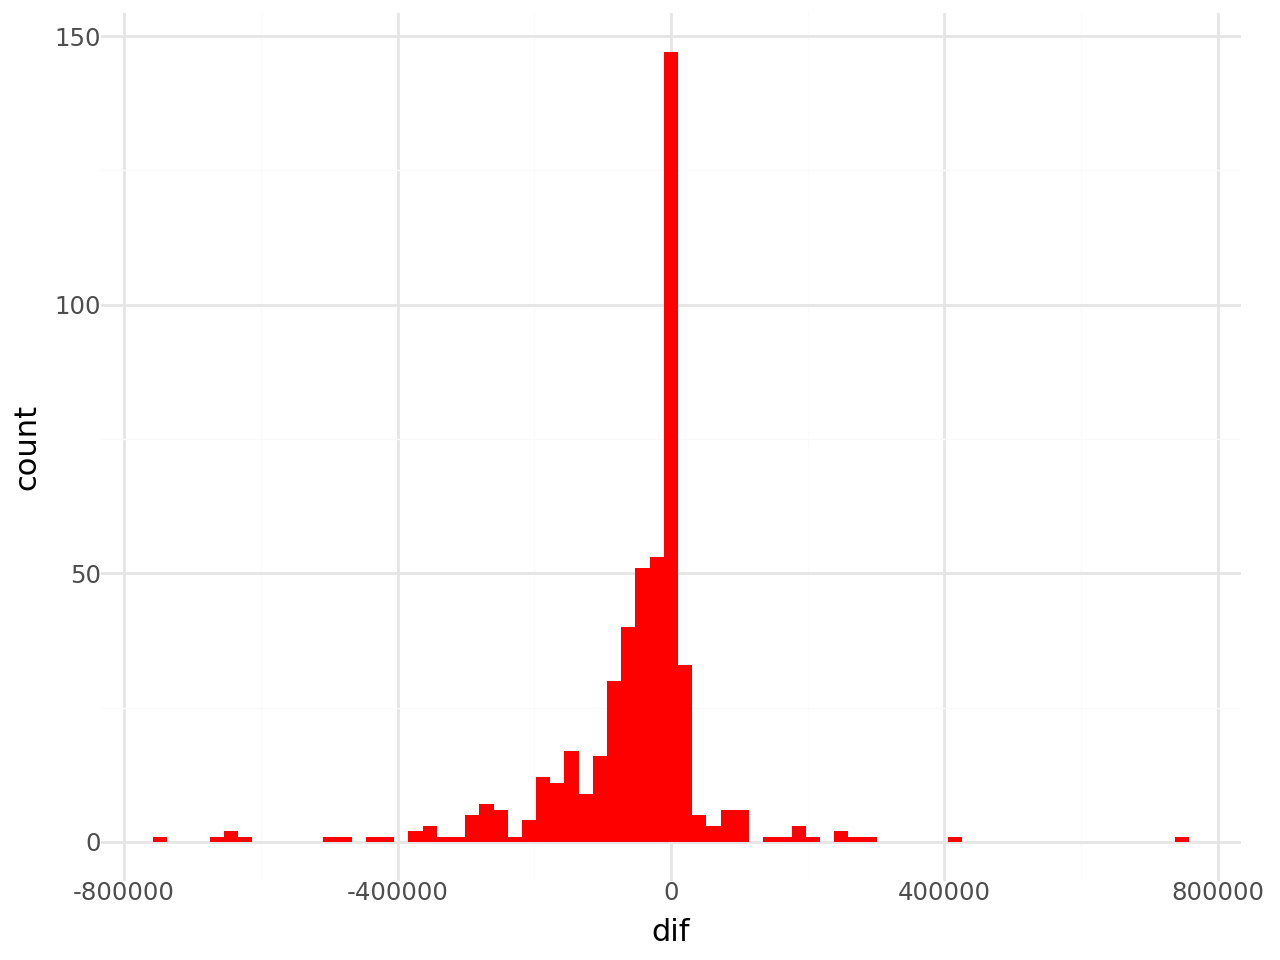

In [31]:
# Checking for whether max capacity estimates may be lower than existing GFA

test = taz_max_capacities.dropna()
test['dif'] = test['max_capacity_gfa'] - test['2022_Ex_GFA']
(p9.ggplot(test,p9.aes(x = 'dif')) +
 p9.geom_histogram(fill = 'red') +
 p9.theme_minimal())

In [32]:
# Creating a dataframe that identifies available capacity for development in each TA|

taz_available_capacity = zone_taz_delta[['ZONE','masterplan_projectid','2022_Ex_GFA','max_capacity','landmodel_component_rank_sum_rank']]
taz_available_capacity = taz_available_capacity[~taz_available_capacity['masterplan_projectid'].isna()]
taz_available_capacity['available_capacity'] = taz_available_capacity['max_capacity'] - taz_available_capacity['2022_Ex_GFA']
taz_available_capacity.head(2)



,ZONE,masterplan_projectid,2022_Ex_GFA,max_capacity,landmodel_component_rank_sum_rank,available_capacity
17,1998,5000.34,4993.0,66537.4,0.457746,61544.4
18,1965,5000.0,120797.0,NaN,0.068182,NaN


In [33]:
# Removing TAZs where there is no available capacity

taz_available_capacity['available_capacity'] = taz_available_capacity['available_capacity'].apply(lambda x: 0 if pd.isna(x) or x < 0 else x)
taz_available_capacity = taz_available_capacity[taz_available_capacity['available_capacity'] > 0]
taz_available_capacity.head(2)



,ZONE,masterplan_projectid,2022_Ex_GFA,max_capacity,landmodel_component_rank_sum_rank,available_capacity
17,1998,5000.34,4993.0,66537.4,0.457746,61544.4
21,1988,5000.0,7595.0,8582.6,0.397727,987.6


In [34]:
# Picking out masterplan ids from those with available capacity

mp_available_capacity_list = taz_available_capacity[['masterplan_projectid']].drop_duplicates()
mp_available_capacity_list = mp_available_capacity_list['masterplan_projectid'].tolist()
print(mp_available_capacity_list)

['5000.34', '5000.0', '1086.3', '1170.0', '1097.40', '1089.62', '1072.0', '1097.34', '17860.0', 'Riyadh', '6034.0', '1113.4', '1113.25', 'Al Faya Industrial - New', '1137.0', '1996.0', '1997.0', '2100.0', '5222.0', '1114.0', '6033.0', '1007.42.4', '1007.38', '1007.45', '1007.27', '15090.1', '21703.0', '1001.8.1', '2115.2.1', '1113.6.12.1', '1164.0', '25983.0', '17407.0', '1113.3.3', '1113.6', '1235.0', '18495.2', '1089.65', '1995.0']


In [35]:
# Creating function for creating dataframes with the cumulative capacity across TAZs in an MP and then ordering them based on the TAZ's scores

def cumulative_capacity_function(mp_list):
    
    df_list = []
    
    for mp in mp_list:
        
        df = taz_available_capacity[taz_available_capacity['masterplan_projectid'] == mp].sort_values(by=['landmodel_component_rank_sum_rank'],ascending = False).reset_index(drop = True)
        df['cum_development'] = df['available_capacity'].cumsum()
        df = df[['masterplan_projectid','ZONE','cum_development']].reset_index(drop =True)
        df_list.append(df) 
    # Concatenate all DataFrames in the list along the rows (axis=0)
    result_df = pd.concat(df_list, axis=0)
    
    return result_df

# Running function

taz_cumulative_capacity = cumulative_capacity_function(mp_available_capacity_list)
taz_cumulative_capacity.head(3)


,masterplan_projectid,ZONE,cum_development
0,5000.34,3358,24379.5
1,5000.34,3396,39500.6
2,5000.34,3359,70349.3


In [72]:
# Creating function to calculate cumulative development per masterplan area by year

mp_cumulative_development= phased_development[['ProjectID', 'year', 'development_pa']]
mp_cumulative_development['cumulative_development'] = mp_cumulative_development.groupby(['ProjectID', 'year'])['development_pa'].cumsum().reset_index(drop=True)
mp_cumulative_development = mp_cumulative_development.drop(['development_pa'],axis=1).drop_duplicates().reset_index(drop = True)
mp_cumulative_development['cumulative_development'] = mp_cumulative_development['cumulative_development'].astype(float)
mp_cumulative_development = mp_cumulative_development[mp_cumulative_development['cumulative_development'] > 0].reset_index(drop = True)
mp_cumulative_development

C:\Users\jtindale\AppData\Local\Temp\ipykernel_12296\296002292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ProjectID,year,cumulative_development
0,1996.0,2024,710.00
1,1170.0,2024,36.50
2,1146.0,2024,76.00
3,1097.40,2024,94.50
4,1633.0,2024,36.00
...,...,...,...
3587,Riyadh,2039,14525.75
3588,Riyadh,2040,1053.15
3589,Riyadh,2040,11245.60
3590,Riyadh,2040,11260.90


In [73]:
taz_cumulative_capacity.loc[]

,masterplan_projectid,ZONE,cum_development
0,5000.34,3358,24379.50
1,5000.34,3396,39500.60
2,5000.34,3359,70349.30
3,5000.34,1998,131893.70
4,5000.34,3348,195163.50
...,...,...,...
1,18495.2,288,1150.30
0,1089.65,306,485.44
1,1089.65,329,985.34
2,1089.65,301,16729.34


In [113]:
test = mp_cumulative_development[mp_cumulative_development['ProjectID'] == '5000.34'].reset_index(drop = True)
test = test[['year','cumulative_development']].T
test_new_column_names = test.iloc[0].tolist()
test.columns = test_new_column_names
test = test.drop('year').reset_index(drop = True)
test.head(1)

,2029.0,2030.0,2031.0,2032.0,2033.0,2034.0,2035.0,2036.0,2037.0,2038.0,2039.0,2040.0
0,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667


In [115]:
test_2 = taz_cumulative_capacity[taz_cumulative_capacity['masterplan_projectid'] == '5000.34']
test_3 = pd.concat([test_2,test], axis = 1)
test_3

,masterplan_projectid,ZONE,cum_development,2029.0,2030.0,2031.0,2032.0,2033.0,2034.0,2035.0,2036.0,2037.0,2038.0,2039.0,2040.0
0,5000.34,3358,24379.5,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667,27603.666667
1,5000.34,3396,39500.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5000.34,3359,70349.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5000.34,1998,131893.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5000.34,3348,195163.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5000.34,3376,271155.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5000.34,3350,341622.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5000.34,3355,380678.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,5000.34,1993,786719.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,5000.34,2006,1045544.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Ingesting MP land use to TAZ land use crosswalk
crosswalks = pd.read_csv('taxonomy_crosswalks.csv')
crosswalks = crosswalks[crosswalks['crosswalk'] == 'MP Committed Development to GIS Use']

# Filtering out the following land uses from the crosswalk dataframe
mp_land_use_exclusion = ['Residential - Labour Accommodation (Units)'] #  Land uses to exclude for the crosswalk
crosswalks = crosswalks[~crosswalks['variable_1'].isin(mp_land_use_exclusion)] # Filtering the crosswalk
crosswalks = crosswalks.drop('Notes',axis = 1) # Dropping notes column
crosswalks


,crosswalk,variable_1,variable_2
0,MP Committed Development to GIS Use,Residential - Villas Emiratis (Units),Villa_Units
1,MP Committed Development to GIS Use,Residential - Villas Non-Emiratis (Units),Villa_Units
2,MP Committed Development to GIS Use,Residential - Apartments (Units),Apt_Units
4,MP Committed Development to GIS Use,Retail (GFA),RETAIL_GFA
5,MP Committed Development to GIS Use,Retail (GFA),Commercial_Recreation_GFA
6,MP Committed Development to GIS Use,Office (GFA),OFFICE_GFA
7,MP Committed Development to GIS Use,Industrial (GFA),INDUSTRIAL_GFA
8,MP Committed Development to GIS Use,Hotel (Units),Hotel_Rooms
9,MP Committed Development to GIS Use,Community Facilities (GFA),RELIGIOUS_GFA
10,MP Committed Development to GIS Use,Community Facilities (GFA),GOV_INST_SOC_CULT_GFA


In [ ]:
# Creating a list columns to create the taz_existing_gfa dataframe

land_uses_2022 = ['ZONE','masterplan_projectid','2022_NUM_OF_BUILDINGS','2022_Calc_Total_Ex_GFA','2022_Ex_GFA','2022_RES_GFA','2022_Residential_Labour_GFA','2022_OFFICE_GFA','2022_RETAIL_GFA','2022_Hotel_GFA','2022_Commercial_Recreation_GFA','2022_Industrial_GFA','2022_SCHOOL_GFA','2022_MED_GFA','2022_RELIGIOUS_GFA','2022_GOV_INST_SOC_CULT_GFA','2022_OPENSPACE_RECREATION_GFA','2022_Community_Facilities_GFA','2022_AGRICULTURE_GFA','2022_OTHER_GFA','2022_ST_Other_GFA','2022_INFRASTRUCTURE_GFA','2022_Hotel_Rooms','2022_Villa_Units','2022_Apt_Units','2022_HH','2022_HOTELROOMS']

# Creating the dataframe with existing TAZ gfa

taz_existing_gfa = zone_taz_delta.loc[:,land_uses_2022]
taz_existing_gfa

,ZONE,masterplan_projectid,2022_NUM_OF_BUILDINGS,2022_Calc_Total_Ex_GFA,2022_Ex_GFA,2022_RES_GFA,2022_Residential_Labour_GFA,2022_OFFICE_GFA,2022_RETAIL_GFA,2022_Hotel_GFA,...,2022_Community_Facilities_GFA,2022_AGRICULTURE_GFA,2022_OTHER_GFA,2022_ST_Other_GFA,2022_INFRASTRUCTURE_GFA,2022_Hotel_Rooms,2022_Villa_Units,2022_Apt_Units,2022_HH,2022_HOTELROOMS
0,1044,None,675.0,295592.0,296118.0,269986.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1124.0,1124.0,753.0,0.0,329.0,11.0,340.0,0.0
1,1310,None,541.0,223794.0,224058.0,152630.0,0.0,0.0,6490.0,0.0,...,0.0,12060.0,16703.0,16703.0,916.0,0.0,154.0,16.0,170.0,0.0
2,2656,None,6.0,1091.0,1091.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1091.0,0.0,0.0,0.0,0.0,0.0
3,1318,None,738.0,102025.0,102379.0,11129.0,0.0,0.0,0.0,0.0,...,0.0,90273.0,90864.0,90864.0,31.0,0.0,2.0,0.0,2.0,0.0
4,1320,None,5.0,8977.0,8977.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8977.0,8977.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,790,1995.0,224.0,195698.0,195698.0,9960.0,0.0,2020.0,0.0,0.0,...,0.0,0.0,29098.0,29098.0,13755.0,0.0,0.0,0.0,0.0,0.0
2434,3474,1995.0,209.0,217530.0,217693.0,24626.0,0.0,749.0,11341.0,0.0,...,0.0,0.0,4024.0,4024.0,64.0,0.0,0.0,0.0,0.0,0.0
2435,787,1994.0,151.0,281700.0,281771.0,9440.0,0.0,0.0,0.0,0.0,...,0.0,0.0,472.0,472.0,162.0,0.0,0.0,0.0,0.0,0.0
2436,3475,1995.0,67.0,105935.0,105935.0,8877.0,0.0,0.0,1931.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
taz_existing_gfa

,ZONE,masterplan_projectid,2022_NUM_OF_BUILDINGS,2022_Calc_Total_Ex_GFA,2022_Ex_GFA,2022_RES_GFA,2022_Residential_Labour_GFA,2022_OFFICE_GFA,2022_RETAIL_GFA,2022_Hotel_GFA,...,2022_Community_Facilities_GFA,2022_AGRICULTURE_GFA,2022_OTHER_GFA,2022_ST_Other_GFA,2022_INFRASTRUCTURE_GFA,2022_Hotel_Rooms,2022_Villa_Units,2022_Apt_Units,2022_HH,2022_HOTELROOMS
0,1044,None,675.0,295592.0,296118.0,269986.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1124.0,1124.0,753.0,0.0,329.0,11.0,340.0,0.0
1,1310,None,541.0,223794.0,224058.0,152630.0,0.0,0.0,6490.0,0.0,...,0.0,12060.0,16703.0,16703.0,916.0,0.0,154.0,16.0,170.0,0.0
2,2656,None,6.0,1091.0,1091.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1091.0,0.0,0.0,0.0,0.0,0.0
3,1318,None,738.0,102025.0,102379.0,11129.0,0.0,0.0,0.0,0.0,...,0.0,90273.0,90864.0,90864.0,31.0,0.0,2.0,0.0,2.0,0.0
4,1320,None,5.0,8977.0,8977.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,8977.0,8977.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433,790,1995.0,224.0,195698.0,195698.0,9960.0,0.0,2020.0,0.0,0.0,...,0.0,0.0,29098.0,29098.0,13755.0,0.0,0.0,0.0,0.0,0.0
2434,3474,1995.0,209.0,217530.0,217693.0,24626.0,0.0,749.0,11341.0,0.0,...,0.0,0.0,4024.0,4024.0,64.0,0.0,0.0,0.0,0.0,0.0
2435,787,1994.0,151.0,281700.0,281771.0,9440.0,0.0,0.0,0.0,0.0,...,0.0,0.0,472.0,472.0,162.0,0.0,0.0,0.0,0.0,0.0
2436,3475,1995.0,67.0,105935.0,105935.0,8877.0,0.0,0.0,1931.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
